# 4.利用隐变量解释

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scvelo as scv
import velovgi

Global seed set to 0
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 数据读入

In [2]:
adata = velovgi.tl.read_adata("./data/adata/")

batch_key = "stage"
cluster_key = "celltype"
pseudotime_key = "velocity_pseudotime"
adata

load ./data/adata//adata.h5ad


AnnData object with n_obs × n_vars = 20000 × 1938
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity

## 2. 隐层表示提取

1. 提取隐变量

In [5]:
epochs = 500
model_dir = "model/%s_epoch(max_epochs=%s)"%(epochs, epochs)
# velovgi_model = velovgi.tl.VELOVGI.load(model_dir, adata=adata, use_gpu=True) # 需要根据gpu进行调换
velovgi_model = velovgi.tl.VELOVGI.load(model_dir, adata=adata, use_gpu=False) # 需要根据gpu进行调换
latent_umap_key = "X_latent_umap"
velovgi.tl.get_latent_umap(adata, velovgi_model, latent_umap_key=latent_umap_key, random_seed=0)

INFO     File model/500_epoch(max_epochs=500)/model.pt already downloaded                                          


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 20000 × 1938
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'velocity_umap', 'X_latent', 'X_latent_umap'
    layers: '

2. 隐变量的降维速率图

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_latent_umap', embedded velocity vectors (adata.obsm)


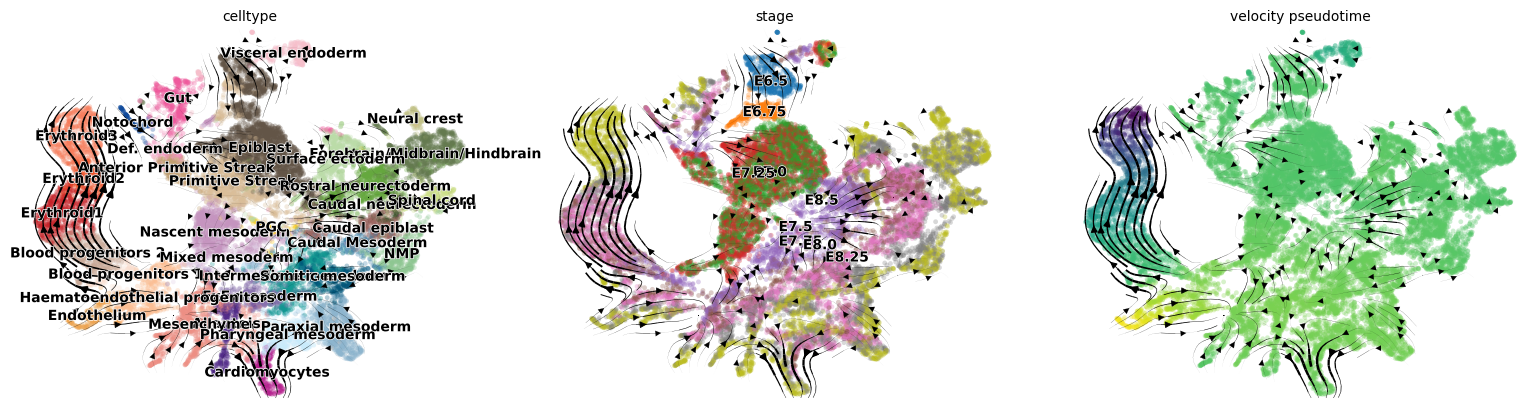

In [6]:
scv.pl.velocity_embedding_stream(adata, color=[cluster_key, batch_key, pseudotime_key], basis=latent_umap_key, colorbar=False)

## 2. 利用网络权重理解

Text(70.72222222222221, 0.5, 'Latent Dimensions')

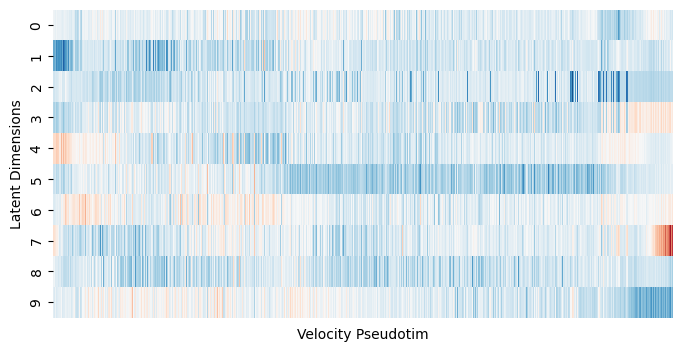

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

figsize = (8, 4)
plt.figure(figsize=figsize)

# 隐变量排序
sorted_index = adata.obs["velocity_pseudotime"].sort_values().index
sorted_adata = adata[sorted_index]
latent_reprentation = sorted_adata.obsm["X_latent"]

# 显示聚类相关的颜色
color_dict = dict(zip(adata.obs[cluster_key].cat.categories, adata.uns["%s_colors"%cluster_key]))
color_list = adata.obs[cluster_key].apply(lambda x: color_dict[x]).to_numpy()

# 绘制隐变量热图
# sns.clustermap(latent_reprentation, row_cluster=False, col_cluster=False, row_colors=color_list, cbar_pos=(1, 0.05, 0.05, 0.3), cmap="RdBu_r")
sns.heatmap(latent_reprentation.T, cmap="RdBu_r", cbar=False) # 不要颜色条
plt.xticks([])
plt.xlabel("Velocity Pseudotim")
plt.ylabel("Latent Dimensions")

2. 编码器的特征提取整体与部分权重可视化

<AxesSubplot: >

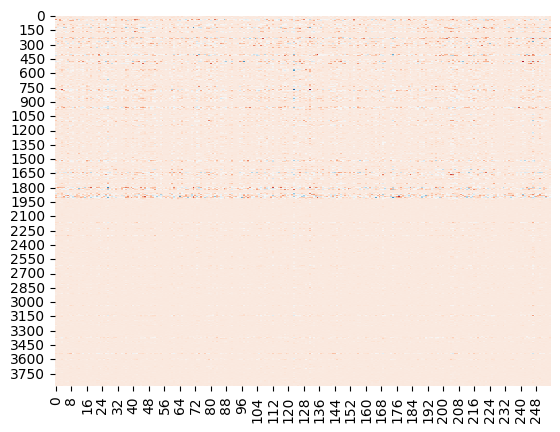

In [8]:
import numpy as np

gcn_weight = velovgi_model.module.z_encoder.encoder.gnn_layers[0][0].lin.weight.detach().cpu().numpy()
sns.heatmap(gcn_weight.T, cmap="RdBu_r", cbar=False)

[951, 1649, 171, 181, 1449]


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
Mdk,-0.189552,0.320600,-0.076898,0.242656,-0.691572,-0.058911,-0.037678,-0.108995,-0.171939,0.283520,...,0.205977,-0.473639,-0.083282,-0.212950,-0.476972,0.258999,0.653302,-0.110605,-0.038847,-0.358619
Rpl18a,-0.451721,-0.350647,-0.552735,-0.715452,-0.203528,0.371916,-0.276280,0.058567,-0.249698,0.355982,...,0.453353,0.213172,0.286872,-0.041781,-0.080667,-0.038181,-0.195229,0.161631,0.069122,0.435278
Cited2,0.159597,0.057915,-0.001940,0.316682,0.090582,-0.288580,0.193768,-0.165158,0.279518,0.097520,...,-0.445781,0.326435,0.012314,-0.223228,-0.438914,-0.361557,-0.322095,0.031409,0.043668,0.160237
Cd24a,0.008241,-0.039894,0.163294,-0.500221,-0.028895,0.203835,-0.124094,-0.176675,0.140655,0.225762,...,-0.402769,-0.244710,-0.134748,-0.356235,-0.053542,-0.562311,-0.031726,-0.137074,-0.025216,0.261812
Ccnd2,-0.068765,0.208644,0.017268,0.140912,-0.317044,0.090250,0.061176,-0.261028,-0.676567,0.068318,...,-0.189734,-0.772603,0.153011,0.182665,-0.454505,-0.021261,0.316837,0.275143,0.082148,-0.087428


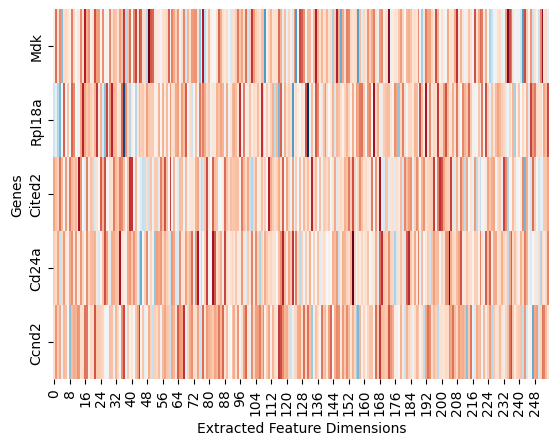

In [9]:
import pandas as pd

n_top = 5
feature_gcn_weight = velovgi_model.module.z_encoder.encoder.gnn_layers[0][0].lin.weight.detach().cpu().numpy()
# index_list = list(np.argsort(feature_gcn_weight.mean(axis=0))[::-1][:n_top])  # 权重最大的前几个
index_list = list(np.argsort(np.abs(feature_gcn_weight).mean(axis=0))[::-1][:n_top])  # 权重绝对值最大的前几个
print(index_list)

gene_index_list = []
for index in index_list:
    if index > 2000:
        index = index-2000
    gene_index_list.append(index)

# 添加基因名
gene_name_list = list(adata.var.iloc[gene_index_list].index)
feature_df = pd.DataFrame(gcn_weight[:, gene_index_list].T)
feature_df.index = gene_name_list

sns.heatmap(feature_df, cmap="RdBu_r", cbar=False)  # 不要颜色条
plt.xlabel("Extracted Feature Dimensions")
plt.ylabel("Genes")

feature_df # 这些基因就可以作为候选的标记基因了

2. 提取与Hbb-y相关性很强的特征

In [14]:
top_n = 5
gene = "Mdk"
positive_feature_index_list = list(np.argsort(feature_df.loc[gene])[::-1][:top_n]) # 与Hbb-y相关的特征
negtive_feature_index_list = list(np.argsort(feature_df.loc[gene])[:top_n]) # Hbb-y负相关的特征

Text(50.722222222222214, 0.5, 'Extracted Feature Dimensions')

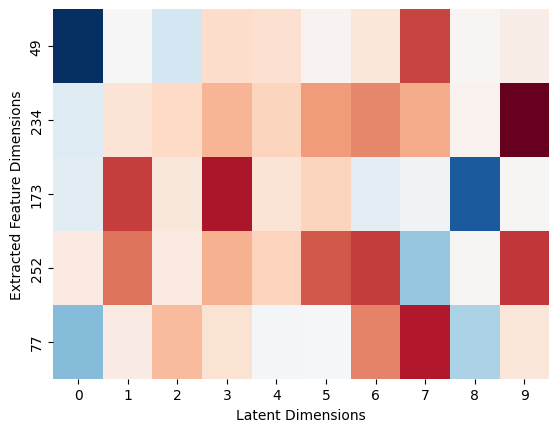

In [15]:
mean_weight = velovgi_model.module.z_encoder.mean_encoder.lin.weight.detach().cpu().numpy()
df = pd.DataFrame(mean_weight[:, positive_feature_index_list].T)
df.index = positive_feature_index_list
sns.heatmap(df, cmap="RdBu_r", cbar=False)
plt.xlabel("Latent Dimensions")
plt.ylabel("Extracted Feature Dimensions")

Text(50.722222222222214, 0.5, 'Extracted Feature Dimensions')

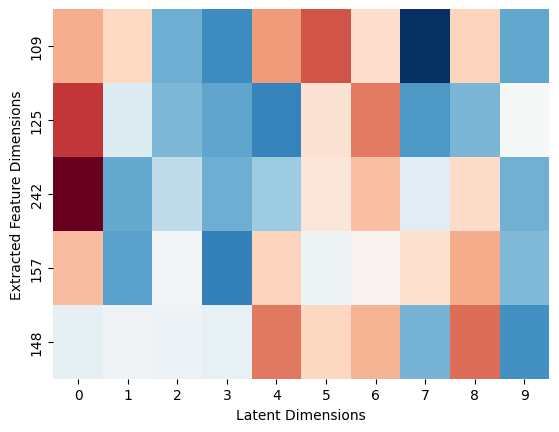

In [16]:
mean_weight = velovgi_model.module.z_encoder.mean_encoder.lin.weight.detach().cpu().numpy()
df = pd.DataFrame(mean_weight[:, negtive_feature_index_list].T)
df.index = negtive_feature_index_list
sns.heatmap(df, cmap="RdBu_r", cbar=False)
plt.xlabel("Latent Dimensions")
plt.ylabel("Extracted Feature Dimensions")